# **Interpolating Depth Factor for Computing Immediate Settlements of Foundations**

**Rizal Purnawan**\
ORCID: [0000-0001-8858-4036](https://orcid.org/0000-0001-8858-4036)

In this notebook, we develop a machine learning model (ML) for an interpolation of depth factors (Das and Sobhan, 2012), which is used in computing the immediate settlement of a foundation. The output of this notebook consists of an ML model and a multilinear function obtained from the ML model.

## **1. Introduction**

When referring to (Das and Sobhan, 2012), one of factors used to compute the immediate settlement of a foundation is the depth factor, denoted by $I_f$. For the detail formula of immediate settlement, the readers are referred to (Das and Sobhan, 2012). Follows from (Das and Sobhan, 2012), the depth factor can be interpreted as a map
$$
(L/B, D_f/B, \mu_s) \mapsto I_f \,,
$$
where $L$ is the length of the foundation, $B$ is the width of the foundation, $D_f$ is the depth of the bottom of foundation and $\mu_s$ is the Poisson's ratio of the soil. A method to determine $I_f$ according to (Das and Sobhan, 2012) is by interpolating the values of $I_f$ based on a table in the reference containing several sample values of the parameters and $I_f$.

With this circumstance, the common approach employed by engineers is performing linear interpolation. The drawback of a direct linear interpolation is the high possibility of inacurracy, since the underlying relation might not be linear at all. To minimize this drawback, we will develop a machine learning (ML) model to interpolate $I_f$ which is expected to provide a better accuracy. We will train a model built from `LinearRegression()` of `sklearn.linear_model` on a dataset of the table mentioned earlier (Das and Sobhan, 2012).

The Python libearies in use is imported in the following cell:

In [ ]:
# Libraries:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use("seaborn-v0_8-white")

# ML libraries:
from sklearn.linear_model import LinearRegression

## **2. Dataset and Preprocessing**

The dataset for the ML model is retrieved from (Das and Sobhan, 2012). We copy the dataset into a `csv` file and is imported in the following cell:

In [ ]:
# Importing the dataset:
path = "/content/drive/MyDrive/Datasets/Depth_Factor_M_Das_p362.csv"
df = pd.read_csv(path)

The dataset is displayed as follows:

In [ ]:
# Displaying the dataset:
df

,L/B,Df/B,poisson,If
0,1,0.50,0.3,0.77
1,1,0.50,0.4,0.82
2,1,0.50,0.5,0.85
3,1,0.75,0.3,0.69
4,1,0.75,0.4,0.74
5,1,0.75,0.5,0.77
6,1,1.00,0.3,0.65
7,1,1.00,0.4,0.69
8,1,1.00,0.5,0.72
9,2,0.50,0.3,0.82


The basic statistical properties related to the dataset is presented as follows:

In [ ]:
# Statistical properties:
def subtitle(nar):
    print("\n" + nar)
    print("-" *len(nar))

# Statistics descriptive:
subtitle("Statistics Descriptive")
display(df.describe())

# Inter-correlations:
subtitle("Inter-correlations (Pearson)")
display(df.corr(method= "pearson"))


Statistics Descriptive
----------------------


,L/B,Df/B,poisson,If
count,27.000000,27.000000,27.000000,27.000000
mean,2.666667,0.750000,0.400000,0.800370
std,1.732051,0.208013,0.083205,0.072509
min,1.000000,0.500000,0.300000,0.650000
25%,1.000000,0.500000,0.300000,0.750000
50%,2.000000,0.750000,0.400000,0.810000
75%,5.000000,1.000000,0.500000,0.855000
max,5.000000,1.000000,0.500000,0.930000



Inter-correlations (Pearson)
----------------------------


,L/B,Df/B,poisson,If
L/B,1.000000e+00,-5.925932e-17,2.222225e-16,0.628831
Df/B,-5.925932e-17,1.000000e+00,4.625929e-17,-0.612007
poisson,2.222225e-16,4.625929e-17,1.000000e+00,0.427130
If,6.288308e-01,-6.120073e-01,4.271301e-01,1.000000


For a more intuitive approach on the analyis of the dataset, let us plot each feature (either `L/B`, `Df/B` or `poisson`) with the target.

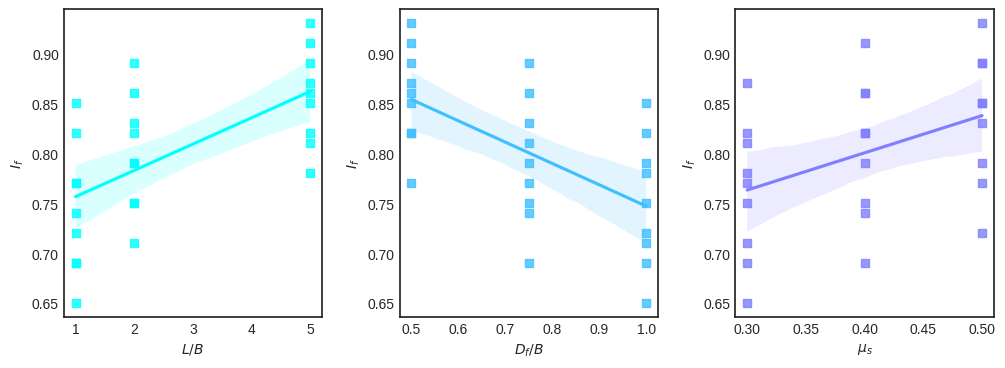

In [ ]:
# Plotting features:
def regplot_data(
        dat, features, target,
        marker= "^", wspace= 0.2,
        cmap= plt.cm.cool,
        xlabels= None, ylabel= None, figsize= None,
        ):
    num_feat = len(features)
    if xlabels is None:
        xlabels = features
    if ylabel is None:
        ylabel= target
    fig, axs = plt.subplots(nrows= 1, ncols= num_feat, figsize= figsize)
    for k, ft in zip(range(num_feat), features):
        fig = sns.regplot(
            x= dat[ft], y= dat[target],
            color= cmap(k / (num_feat + 1)), marker= marker,
            ax= axs[k]
        )
        axs[k].set(xlabel= xlabels[k], ylabel= ylabel)
    fig = plt.subplots_adjust(wspace= wspace)
    fig = plt.show()

regplot_data(
    df, list(df.columns[:-1]),
    "If",
    marker= "s", ylabel= r"$I_f$", wspace= 0.3,
    xlabels= [r"$L/B$", r"$D_f/B$", r"$\mu_s$"],
    figsize= (3 *4, 4)
    )

The plots above confirm the numerical results of the correlations. Now we proceed building the ML model.

## **3. Machine Learning Model**

We will use `LinearRegression` from `sklearn.linear_model` for the ML model. The development of the model is conducted in the following cell:

In [ ]:
# Developing the ML model:

# Algorithm for error estimates:
def r_norm2(X, Y):
    EX = [np.mean(X)] *len(X)
    norm = np.linalg.norm
    return (
        norm(np.array(X) - np.array(Y))**2 /
        norm(np.array(X) - np.array(EX))**2
    )

def mae(X, Y):
    A, B = list(X), list(Y)
    return np.mean([abs(a - b) for a, b in zip(A, B)])

# Splitting the data into training and validation:
df_train = df.sample(frac= 0.8, random_state= 42)
df_valid = pd.DataFrame(
    df, index= [i for i in df.index if i not in df_train]
    )
X_train = df_train.drop("If", axis= 1)
X_valid = df_valid.drop("If", axis= 1)
y_train = df_train["If"]
y_valid = df_valid["If"]

model = LinearRegression()
_ = model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

mae_err = mae(y_valid, y_pred)
sq_rnorm = r_norm2(y_valid, y_pred)

# Model accuracy result:
def model_acc():
    nar = "Model Accuracy"
    print(nar)
    print("-" *len(nar))
    print(f"MAE = {round(mae_err, 3)}")
    print(f"r-Norm2 = {round(sq_rnorm, 3)}")

model_acc()

Model Accuracy
--------------
MAE = 0.013
r-Norm2 = 0.05


The validation of the model provides a very satisfactory result with the following error metrics:
1. $\mathrm{MAE}(Y, \hat{Y}) = 0.013$
2. $\|Y - \hat{Y}\|_{2:Y - \mathrm{E}[Y]} = 0.05$
3. $R^2 = 1 - \|Y - \hat{Y}\|_{2:Y - \mathrm{E}[Y]} = 0.995$

With this result, we proceed with the model.

# **4. Conclusion and Use of the ML Model**

We will also upload the model in the same directory with this notebook. Readers are free to use the model. Alternatively, we can print the weights of the ML model and formulate a function by making use of the weights as coefficients. The weights are given as follows:

In [ ]:
# Coefficients from Model's Weights:
coefficients = [model.intercept_] + list(model.coef_)
coef_df = pd.DataFrame(
    {
        "Coefficient": [f"b{k}" for k in range(4)],
        "Value": coefficients
    }
)
coef_df

,Coefficient,Value
0,b0,0.739085
1,b1,0.025799
2,b2,-0.198381
3,b3,0.353371


The function for $I_f$ is given by
\begin{align*}
    I_f
    &= \beta_0 + \beta_1 \frac{L}{B} + \beta_2 \frac{D_f}{B} + \beta_3 \mu_s \\
    &= 0.739085 + 0.025799 \cdot \frac{L}{B} -0.198381 \cdot \frac{D_f}{B} + 0.353371 \cdot \mu_s
    \,.
\end{align*}
As an alternative to using the model, the readers can use the equation above to compute $I_f$ with a given $L/B$, $D_f/B$ and $\mu_s$.

*Note: $\beta_0, \dotsc, \beta_3$ in the eqaution are designated to be `b0`,... , `b3` on the table above.*

## **Referece**

Das, B. M. and Sobhan, K. (2012). *Principles of Geotechnical Engineering*. page 362. Cengage Learning.